Importing the libraries

In [81]:
import sklearn
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
import numpy as np

Read data file

In [82]:
df = pd.read_csv("out_without_nan_mood_normalised_extra_temp_train.csv")

Add dummies, remove weekDay mean, remove day mean

In [83]:
df['mood_mean_TARGET'] = df['mood_mean_TARGET'].astype(float)
df = pd.concat([df,pd.get_dummies(df['id'])],axis=1)
df = pd.concat([df,pd.get_dummies(df['weekDay'],prefix="day_")],axis=1)
df = df.drop(['weekDay_time_5','day_time_5','weekDay_time_4','day_time_4','weekDay_time_3','day_time_3','weekDay_time_2','day_time_2','weekDay_time_1','day_time_1','weekDay_time_5','mood_mean_time_1','circumplex.valence_mean_time_1'],axis=1)
df = df.fillna(0)
df = df.loc[:, (df != 0).any(axis=0)]

Split in train and test set

In [84]:
corr=df.corr()
goodColumns= corr[abs(corr['mood_mean_TARGET'])>0.25]['mood_mean_TARGET'].sort_values()
goodColumns = goodColumns.drop(['mood_mean_TARGET'])
print(goodColumns)


numberOfTimesSeenMood5Days_5     -0.327055
numberOfTimesSeenMood5Days_4     -0.314874
AS14.07                          -0.272723
lastTimeSeenMood_7               -0.268945
numberOfTimesSeenMood5Days_6     -0.261476
circumplex.valence_mean_time_3    0.260973
circumplex.valence_mean_time_5    0.273790
circumplex.valence_mean_time_4    0.275021
circumplex.valence_mean_time_2    0.291143
circumplex.valence_mean           0.300689
mood_mean                         0.479960
mood_mean_time_3                  0.485320
mood_mean_time_2                  0.502291
mood_mean_time_4                  0.509455
mood_mean_time_5                  0.522146
Name: mood_mean_TARGET, dtype: float64


In [85]:
notRelevantAll=df.drop(['id','date'],axis=1).dropna()
goldY= notRelevantAll['mood_mean_TARGET']
relevant = notRelevantAll.drop(['mood_mean_TARGET'],axis=1)

In [86]:
clf = sklearn.svm.SVR(gamma="scale",kernel="rbf")

Define scoring

In [87]:
scoring = {'R2': 'r2',
           'Mean squared Error': 'neg_mean_squared_error',
           'Explained variance': 'explained_variance'}

In [88]:
testColumns = ['appCat.office_sum', 'mood_mean_time_2', 'appCat.communication_sum_time_2', 'appCat.office_sum_time_2', 'appCat.travel_sum_time_2', 'call_sum_time_2', 'mood_mean_time_3', 'appCat.office_sum_time_3', 'screen_sum_time_3', 'appCat.communication_sum_time_4', 'appCat.finance_sum_time_4', 'screen_sum_time_4', 'mood_mean_time_5', 'appCat.communication_sum_time_5', 'appCat.finance_sum_time_5', 'appCat.game_sum_time_5', 'appCat.travel_sum_time_5', 'screen_sum_time_5', 'lastTimeSeenMood_4', 'numberOfTimesSeenMood5Days_4', 'numberOfTimesSeenMood5Days_5', 'numberOfTimesSeenMood5Days_6']

In [89]:
scores = cross_validate(clf, relevant[goodColumns.keys()], goldY, cv=7,scoring=scoring)

print("R2: %0.2f (+/- %0.2f)" % (scores['test_R2'].mean(), scores['test_R2'].std() * 2))
print("MSE: %0.2f (+/- %0.2f)" % (scores['test_Mean squared Error'].mean(), scores['test_Mean squared Error'].std() * 2))
print("EXPLAINED VARIANCE: %0.2f (+/- %0.2f)" % (scores['test_Explained variance'].mean(), scores['test_Explained variance'].std() * 2))


R2: 0.27 (+/- 0.16)
MSE: -0.39 (+/- 0.14)
EXPLAINED VARIANCE: 0.28 (+/- 0.16)


In [90]:
clf.fit(relevant[goodColumns.keys()], goldY)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [91]:
dfTest = pd.read_csv("out_without_nan_mood_normalised_extra_temp_test.csv")
dfTest['mood_mean_TARGET'] = dfTest['mood_mean_TARGET'].astype(float)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['id'])],axis=1)
dfTest = pd.concat([dfTest,pd.get_dummies(dfTest['weekDay'],prefix="day_")],axis=1)

MAE
0.4616314829408122
MSE
0.3901536174557047
RMSE
0.6246227801286988
R2
0.25990286870736257


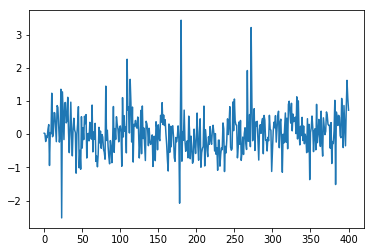

In [92]:
y_pred =clf.predict(dfTest[goodColumns.keys()])
print("MAE")
print(metrics.mean_absolute_error(dfTest['mood_mean_TARGET'],y_pred))
print("MSE")
print(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred))
print("RMSE")
print(np.sqrt(metrics.mean_squared_error(dfTest['mood_mean_TARGET'],y_pred)))
print("R2")
print(metrics.r2_score(dfTest['mood_mean_TARGET'],y_pred))

import matplotlib.pyplot as plt
plt.plot(y_pred-dfTest['mood_mean_TARGET'])
plt.show()